#simple agent architecture with function calling more than one tool inside
keep going on and making calling to the function:
3openai_functioncalling

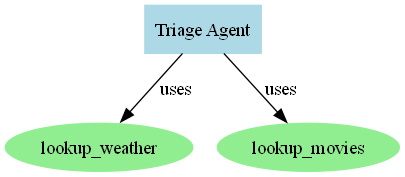


Response from gpt-4o on github: 

lookup_weather
{"city_name": "Vancouver"}
lookup_movies
{"city_name": "Vancouver", "genre": "action"}


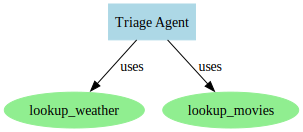

Graph saved and displayed as functioncalling.png


In [ ]:

import os
import openai
from dotenv import load_dotenv
import azure.identity
from agents.extensions.visualization import draw_graph
from IPython.display import display
from dataclasses import dataclass
from typing import List
from graphviz import Digraph


# Setup the OpenAI client to use either Azure OpenAI or GitHub Models
load_dotenv(override=True)
API_HOST = os.getenv("API_HOST", "github")

if API_HOST == "github":
    client = openai.OpenAI(base_url="https://models.inference.ai.azure.com", api_key=os.environ["GITHUB_TOKEN"])
    MODEL_NAME = os.getenv("GITHUB_MODEL", "gpt-4o")
elif API_HOST == "azure":
    token_provider = azure.identity.get_bearer_token_provider(azure.identity.DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
    client = openai.AzureOpenAI(
        api_version=os.environ["AZURE_OPENAI_VERSION"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        azure_ad_token_provider=token_provider,
    )
    MODEL_NAME = os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"]

tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_weather",
            "description": "Lookup the weather for a given city name or zip code.",
            "parameters": {
                "type": "object",
                "properties": {
                    "city_name": {
                        "type": "string",
                        "description": "The city name",
                    },
                    "zip_code": {
                        "type": "string",
                        "description": "The zip code",
                    },
                },
                "additionalProperties": False,
            },
        },
    },
    

    {
    "type": "function",
    "function": {
        "name": "lookup_movies",
        "description": "Find movies playing in theaters near a specific city.",
        "parameters": {
            "type": "object",
            "properties": {
                "city_name": {
                    "type": "string",
                    "description": "The name of the city where the user wants to find movies.",
                },
                "genre": {
                    "type": "string",
                    "description": "Always give one example of genre (e.g., action, comedy, horror).",
                },
            },
            "required": ["city_name"],
            "additionalProperties": False,
        },
    },
}


]

response = client.chat.completions.create(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "You are a tourism assistant that always uses both available tools to respond."},
        {"role": "user", "content": "I’m planning to visit Vancouver this weekend. What’s the weather like and are there any movies playing in theaters?"},
    ],
    tools=tools, #declarative here tools you created before
    tool_choice="auto",
)

print(f"Response from {MODEL_NAME} on {API_HOST}: \n")
if hasattr(response.choices[0].message, "tool_calls") and response.choices[0].message.tool_calls:
    for call in response.choices[0].message.tool_calls:
        print(call.function.name)
        print(call.function.arguments)
else:
    print("No tool was called.")
    print("Model response:", response.choices[0].message.content)


#Visualization part
@dataclass
class Tool:
    name: str
    description: str

@dataclass
class Agent:
    name: str
    instructions: str
    model: object
    tools: List[Tool]

def draw_graph(agent, filename="functioncalling"):
    dot = Digraph()

    # Agent node
    dot.node(agent.name, shape="box", style="filled", color="lightblue", label=agent.name)

    # Tool nodes and connections
    for tool in agent.tools:
        dot.node(tool.name, shape="ellipse", style="filled", color="lightgreen", label=tool.name)
        dot.edge(agent.name, tool.name, label="uses")

    # Save and display
    dot.render(filename=filename, format="png", cleanup=True)
    display(dot)
    return filename

# Define tools and agent
lookup_weather_tool = Tool("lookup_weather", "Lookup the weather for a given city name or zip code.")
lookup_movies_tool = Tool("lookup_movies", "Lookup movies playing in a given city name or zip code.")

triage_agent = Agent(
    name="Triage Agent",
    instructions="Route to the correct tool (weather or movies).",
    model=MODEL_NAME,
    tools=[lookup_weather_tool, lookup_movies_tool]
)

# Draw and display the graph
gz_source = draw_graph(triage_agent, filename="functioncalling")
print("Graph saved and displayed as functioncalling.png")

#one Agent doing calls and using all available tools until finally get the final answer.
5openai_agents_tools

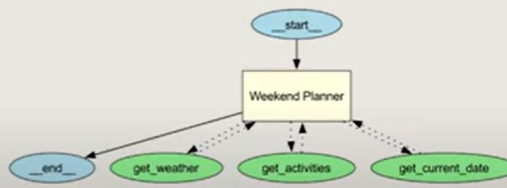

Modifications:
await main() Jupyter already has an event loop, so await is safe and clean
nest_asyncio.apply() Fixes issues when calling await multiple times inside notebook cells.
Remove __main__ block Not needed, since cells run automatically in notebook style.

In [ ]:

import asyncio
import logging
import os
import random
from datetime import datetime

import azure.identity
import openai
from agents import Agent, OpenAIChatCompletionsModel, Runner, function_tool, set_tracing_disabled
from dotenv import load_dotenv
from rich.logging import RichHandler

import nest_asyncio
nest_asyncio.apply()

# Setup logging with rich
logging.basicConfig(level=logging.WARNING, format="%(message)s", datefmt="[%X]", handlers=[RichHandler()])
logger = logging.getLogger("weekend_planner")

# Disable tracing
set_tracing_disabled(disabled=True)

# Load environment variables
load_dotenv(override=True)
API_HOST = os.getenv("API_HOST", "github")

# Setup OpenAI client
if API_HOST == "github":
    client = openai.AsyncOpenAI(
        base_url="https://models.inference.ai.azure.com", 
        api_key=os.environ["GITHUB_TOKEN"]
    )
    MODEL_NAME = os.getenv("GITHUB_MODEL", "gpt-4o")
elif API_HOST == "azure":
    token_provider = azure.identity.get_bearer_token_provider(
        azure.identity.DefaultAzureCredential(), 
        "https://cognitiveservices.azure.com/.default"
    )
    client = openai.AsyncAzureOpenAI(
        api_version=os.environ["AZURE_OPENAI_VERSION"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        azure_ad_token_provider=token_provider,
    )
    MODEL_NAME = os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"]

# Tools
@function_tool
def get_weather(city: str) -> str:
    logger.info(f"Getting weather for {city}")
    if random.random() < 0.05:
        return {
            "city": city,
            "temperature": 72,
            "description": "Sunny",
        }
    else:
        return {
            "city": city,
            "temperature": 60,
            "description": "Rainy",
        }

@function_tool
def get_activities(city: str, date: str) -> list:
    logger.info(f"Getting activities for {city} on {date}")
    return [
        {"name": "PLAY SOCCER", "location": city},
        {"name": "CHILLI AT HOME", "location": city},
        {"name": "STUDY TIME", "location": city},
    ]

@function_tool
def get_current_date() -> str:
    logger.info("Getting current date")
    return datetime.now().strftime("%Y-%m-%d")

# Agent
agent = Agent(
    name="Weekend Planner",
    instructions="You help users plan their weekends and choose the best activities for the given weather. Include the date of the week in your response.",
    tools=[get_weather, get_activities, get_current_date],
    model=OpenAIChatCompletionsModel(model=MODEL_NAME, openai_client=client),
)

# Main async function
async def main():
    result = await Runner.run(agent, input="hii what can I do this week in Vancouver ?")
    print(result.final_output)

# Run it
logger.setLevel(logging.INFO)
await main()


[16:30:11] INFO     Getting current date                                                           ]8;id=516468;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py\4199659470.py]8;;\:]8;id=958466;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py#74\74]8;;\

[16:30:13] INFO     Getting weather for Vancouver                                                  ]8;id=441392;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py\4199659470.py]8;;\:]8;id=594650;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py#49\49]8;;\

           INFO     Getting activities for Vancouver on 2025-05-10                                 ]8;id=331348;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py\4199659470.py]8;;\:]8;id=819951;file://C:\Users\MuriloFarias\AppData\Local\Temp\ipykernel_15828\4199659470.py#65\65]8;;\

This weekend in Vancouver (Saturday, May 10, 2025), the weather is expected to be rainy, with a temperature of 60°F. Here are some activity options:

1. **Play Soccer** - Stay active outdoors if the rain isn’t too heavy.
2. **Chill at Home** - Enjoy a relaxing day indoors, maybe watching your favorite shows or movies.
3. **Study Time** - Utilize the rainy day to focus on learning or catching up on any projects.

Let me know if you'd like specific recommendations or tips for any of these activities!
